<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
<div hidden>
    $$
    \newcommand{\reals}{\mathbb{R}}
    \newcommand{\naturals}{\mathbb{N}}
    \newcommand{\integers}{\mathbb{Z}}
    \newcommand{\prob}{\mathbb{P}}
    \newcommand{\expect}{\mathbb{E}}
    \newcommand{\b}[1]{\mathbf{#1}}
    \newcommand{\bs}[1]{\boldsymbol{#1}}
    \newcommand{\c}[1]{\mathcal{#1}}
    \newcommand{mat}[2]{\left[\,\begin{array}{#1}#2\end{array}\,\right]}
    $$
</div>

# COMPSCI 371 Homework 3

_**Group Members:**_

### Problem 0 (3 points)

## Part 1: Stochastic Gradient Descent

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='fall24', homework=3):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci371/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [2]:
retrieve('helpers.py', homework=2)

Downloaded file helpers.py


In [3]:
from helpers import Stepper
from autograd import numpy as anp
import numpy as snp


def gradient_descent(
    f, z, alpha, min_step=1.e-6, max_iter=10000, history=False, **kwargs
):
    step = Stepper(f, z, alpha, history=history, **kwargs)
    z, fz, gz = anp.copy(z), step.fz0, step.gz0
    for k in range(max_iter):
        s, z, fz, gz = step(z, **kwargs)
        if anp.linalg.norm(s) < min_step:
            break
    step.show_history()
    return fz, z, k

In [4]:
import pickle


file_name = 'students.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    students = pickle.load(file)

Downloaded file students.pkl


### Problem 1.1

In [15]:
x_tr = students.train.x
y_tr = students.train.y
x_ts = students.test.x
y_ts = students.test.y
print(x_tr.shape, y_tr.shape)

(5000, 4) (5000,)


In [39]:
from sklearn.linear_model import LinearRegression
import numpy as snp

X = LinearRegression()
X.fit(x_tr, y_tr)

w = X.coef_
b = X.intercept_
v = snp.round([b] + list(w), 3)
print(f'the v vector for the training set is {v}')

the v vector for the training set is [0.552 0.074 0.176 0.008 0.005]


In [55]:
def rms(v, x, y):
    b, w = v[0], v[1:]

    y_hat = x @ w + b

    diff = y_hat - y

    normalized_diff = ((snp.sum((diff**2))) / len(y))**(1/2)

    true_y = ((snp.sum(y**2)) / len(y)) ** (1/2)

    return snp.round((normalized_diff / true_y), 4)

In [63]:
train_error = rms(v, x_tr, y_tr)
test_error = rms(v, x_ts, y_ts)
print(f'training error: {train_error}')
print(f'test error: {test_error}')


training error: 0.0351
test error: 0.0355


Yes, the predictor performs well because the root means squared error is very low, meaning the parameters from the linear regression problem 
 fit the training data well

Yes, the model also generalizes well becuase when it is used on previously unseen data it performs accurately with a small loss.

### Problem 1.2

In [195]:
def risk(v, x, y, indices=None):
    if indices is not None:
        x = x[indices, :]
        y = y[indices]

    b = v[0]     
    w = anp.array(v[1:])
    y_hat = anp.dot(x, w) + b
    res = y_hat - y
    res_2 = res**2
    sum_res = sum(res_2)
    loss_normalized = sum_res / len(y) 
    
    return loss_normalized



In [202]:
v = anp.array([5,1,2,3,4])

risk1 = anp.round(risk(v, x_tr, y_tr), 4)
risk2 = anp.round(risk(v, x_tr, y_tr, indices=range(100)), 4)
risk3 = anp.round(risk(v, x_tr, y_tr, indices=range(-100, 0)), 4)

print(f'risk of the entire training set: {risk1}')
print(f'risk of the first 100 training samples: {risk2}')
print(f'risk of the last 100 training samples: {risk3}')


risk of the entire training set: 50.1153
risk of the first 100 training samples: 44.3617
risk of the last 100 training samples: 53.2272


### Problem 1.3

In [203]:
def gradient_descent(
    f, z, alpha, min_step=1.e-6, max_iter=10000, history=False, **kwargs
):
    step = Stepper(f, z, alpha, history=history, **kwargs)
    z, fz, gz = anp.copy(z), step.fz0, step.gz0
    for k in range(max_iter):
        s, z, fz, gz = step(z, **kwargs)
        if anp.linalg.norm(s) < min_step:
            break
    step.show_history()
    return fz, z, k


In [207]:
from random import shuffle
import numpy as np
from autograd import numpy as anp
from math import sqrt
from helpers import Stepper

def sgd(
    h, v, alpha=1.e-3, x=None, y=None, batch_size=None,
    min_step=1.e-6, max_epochs=500, history=True
):
    
    size = len(x)
    grad = Stepper(h, v, alpha, history=history, x=x, y=y)
    d = len(v)
    v0 = anp.zeros(d)

    if batch_size is None:
        batch_size = size 

    fz = None
    for i in range(max_epochs):
        idx = list(range(size))
        shuffle(idx)

        v0 = anp.copy(v)
        for j in range(0, size, batch_size):
            b_idx = idx[j:j+batch_size]
            res = grad(v, x=x, y=y, indices=b_idx)
            v = res[1]
        norm_diff = anp.linalg.norm(v - v0)
        
        if norm_diff < min_step:
            break
            
    if history:
        grad.show_history()

    return res[0], v, i

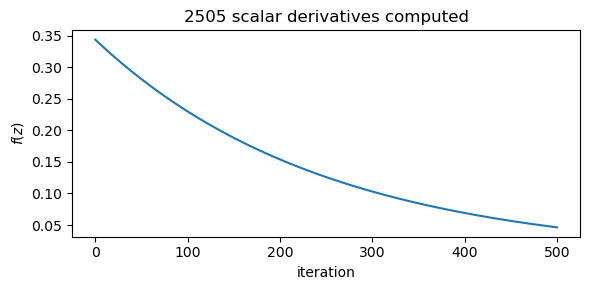

Number of epochs: 499
Optimal v: [0.34970492 0.04901309 0.1122324  0.00662823 0.00599935]


In [208]:
v_initial = anp.zeros(5)

fz, optimal_v, epochs = sgd(risk, v_initial, x=x_tr, y=y_tr)

print(f"Number of epochs: {epochs}")
print(f"Optimal v: {optimal_v}")

### Problem 1.4 (Exam Style)

### Problem 1.5

### Problem 1.6 (Exam Style)

### Problem 1.7 (Exam Style)

## Part 2: Linear Score-Based Classifiers

### Problem 2.1 (Exam Style)

### Problem 2.2 (Exam Style)

### Problem 2.3 (Exam Style)

### Problem 2.4

In [17]:
import pickle

file_name = 'classifiers.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    classifiers = pickle.load(file)

Using previously downloaded file classifiers.pkl


### Problem 2.5

## Part 3: Linear Classification of Handwritten Digits 

In [39]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
x_train, x_test, y_train, y_test = train_test_split(
    digits.data, digits.target, train_size=900, shuffle=False
)
mnist = SimpleNamespace(
    train=SimpleNamespace(x=x_train, y=y_train),
    test=SimpleNamespace(x=x_test, y=y_test)
)

### Problem 3.1

### Problem 3.2 (Exam Style)